# Jet mass regression for W-jets

This is a simple example on Delphes-created FCC-simulations for W-jets

In [1]:
from __future__ import print_function
import  keras, ROOT
import  logging, math, numpy as np
import  data_helpers

# Import some keras deps
from    keras.models       import Sequential
from    keras.layers       import Dense, Dropout, MaxPooling1D, Flatten, Conv1D
from    keras.regularizers import l2
import  keras.backend

Using TensorFlow backend.


Welcome to JupyROOT 6.12/06


In [2]:
# Settings
filename = './w_all.root'
numTrainEvents = 19000
numValEvents   = 19000
learningRate   = 0.01
numEpochs      = 4

In [3]:
# Load data
data      = data_helpers.LoadDataConstituents(filename, numTrainEvents)
val_data  = data_helpers.LoadDataConstituents(filename, numValEvents, offset=numTrainEvents)
truth     = data_helpers.LoadTruth(filename, numTrainEvents)
val_truth = data_helpers.LoadTruth(filename, numValEvents, offset=numTrainEvents)

#### NOTE: Only one data class necessary


In [4]:
# Define model
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(len(data[0]), 4)))
model.add(Dropout(0.1))
model.add(Conv1D(64, 3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.1))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.1))
model.add(Conv1D(128, 3, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1, activation='linear', kernel_initializer='normal'))

#### NOTE: Network output different for regression task (no sigmoid)


# Compile model, here loss function and optimizer are set
model.summary()
model.compile(loss='mean_absolute_error', optimizer='adam')

#### NOTE: Loss function depends on what you want to achieve!

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 38, 64)            832       
_________________________________________________________________
dropout_1 (Dropout)          (None, 38, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 36, 64)            12352     
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 64)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 128)           24704     
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 128)           0         
__________

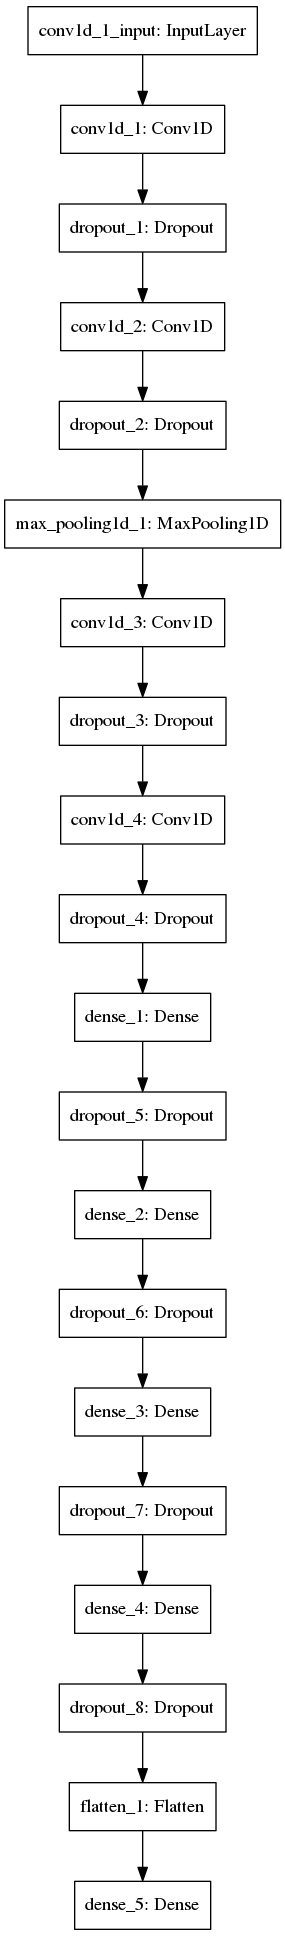

In [5]:
# Visualize model
from keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='model.png')
Image('model.png')

In [6]:
np.set_printoptions(precision=3, suppress=True)
print('Sample 312 (truth={}):'.format(truth[312,0]))
print(data[312])

#### NOTE: Truth is floating-point value


Sample 312 (truth=80.8101959229):
[[    1.085     0.798    -1.135     1.   ]
 [    0.764     0.75     -1.138     1.   ]
 [  131.36      0.787    -1.137     0.   ]
 [   29.272     0.781    -1.15      1.   ]
 [  222.212     0.785    -1.144     2.   ]
 [   30.009     0.784    -1.138     0.   ]
 [   26.051     0.756    -1.141     0.   ]
 [   34.705     0.77     -1.126     0.   ]
 [   42.89      0.78     -1.149     0.   ]
 [  152.401     0.776    -1.15      1.   ]
 [ 1023.778     0.761    -1.138     0.   ]
 [   42.239     0.768    -1.15      1.   ]
 [  454.432     0.763    -1.139     0.   ]
 [  132.613     0.763    -1.139     0.   ]
 [   96.901     0.765    -1.135     0.   ]
 [  154.127     0.764    -1.136     0.   ]
 [  471.306     0.764    -1.139     0.   ]
 [   20.433     0.778    -1.136     0.   ]
 [  218.711     0.767    -1.136     0.   ]
 [   15.493     0.77     -1.135     0.   ]
 [ 1097.467     0.77     -1.136     1.   ]
 [   47.482     0.777    -1.142     0.   ]
 [ 1600.065     0.77

In [7]:
### Actual training is done here ###

keras.backend.set_value(model.optimizer.lr, learningRate) # set learning rate
hist = model.fit(data, truth[:,0], epochs=numEpochs, batch_size=100,
            validation_data=(val_data, val_truth[:,0]), verbose=1)

Train on 19000 samples, validate on 19000 samples
Epoch 1/4
19000/19000 [==============================] - 69s 4ms/step - loss: 62.4817 - val_loss: 30.5997
Epoch 2/4
19000/19000 [==============================] - 69s 4ms/step - loss: 31.4305 - val_loss: 28.7684
Epoch 3/4
19000/19000 [==============================] - 68s 4ms/step - loss: 29.9893 - val_loss: 29.0107
Epoch 4/4
19000/19000 [==============================] - 69s 4ms/step - loss: 29.0440 - val_loss: 28.0725


In [8]:
##############

# Calculate some simple estimators for regression performance
plotStdDeviation = ROOT.TH1D("plotStdDeviation", "Standard deviation", 100, 0, 300)
plotRelDeviation = ROOT.TH1D("plotRelDeviation", "Relative deviations", 100, -5, 5)
plotAbsDeviation = ROOT.TH1D("plotAbsDeviation", "Absolute deviations", 100, -150, 150)
plotStdDeviation_recoMass = ROOT.TH1D("plotStdDeviation_recoMass", "Standard deviation, calculated estimate", 100, 0, 300)
plotRelDeviation_recoMass = ROOT.TH1D("plotRelDeviation_recoMass", "Relative deviations, calculated estimate", 100, -5, 5)
plotAbsDeviation_recoMass = ROOT.TH1D("plotAbsDeviation_recoMass", "Absolute deviations, calculated estimate", 100, -150, 150)

#Cosmetics
plotStdDeviation.SetStats(0)
plotRelDeviation.SetStats(0)
plotAbsDeviation.SetStats(0)
plotStdDeviation.GetXaxis().SetTitle('Standard deviation')
plotRelDeviation.GetXaxis().SetTitle('Relative deviation')
plotAbsDeviation.GetXaxis().SetTitle('Absolute deviation')

predictions = model.predict(val_data, batch_size=100, verbose=0)
for i in range(len(predictions)):
  predicted = predictions[i][0]
  trueValue = val_truth[i,0]

  deviation    = (trueValue - predicted)
  relDeviation = (trueValue - predicted)/trueValue if trueValue else 0
  sumOfSquares = (trueValue - predicted) * (trueValue - predicted)

  plotStdDeviation.Fill(math.sqrt(sumOfSquares))
  plotRelDeviation.Fill(relDeviation)
  plotAbsDeviation.Fill(deviation)

  predicted = val_truth[i,1] # jet mass reconstructed
  deviation    = (trueValue - predicted)
  relDeviation = (trueValue - predicted)/trueValue if trueValue else 0
  sumOfSquares = (trueValue - predicted) * (trueValue - predicted)

  plotStdDeviation_recoMass.Fill(math.sqrt(sumOfSquares))
  plotRelDeviation_recoMass.Fill(relDeviation)
  plotAbsDeviation_recoMass.Fill(deviation)

plotStdDeviation_recoMass.SetLineColor(ROOT.kRed)
plotRelDeviation_recoMass.SetLineColor(ROOT.kRed)
plotAbsDeviation_recoMass.SetLineColor(ROOT.kRed)


legend1 = ROOT.TLegend(0.6, 0.70, 0.9, 0.9)
legend1.SetTextSize(0.03)
legend1.AddEntry(plotStdDeviation, '#splitline{m_{pred.} vs. m_{truth}}{' + '(m={:2.2f}, #sigma={:2.2f})'.format(plotStdDeviation.GetMean(), plotStdDeviation.GetRMS()) + '}')
legend1.AddEntry(plotStdDeviation_recoMass, '#splitline{m_{reco.} vs. m_{truth}}{' + '(m={:2.2f}, #sigma={:2.2f})'.format(plotStdDeviation_recoMass.GetMean(), plotStdDeviation_recoMass.GetRMS()) + '}')
canvas1 = ROOT.TCanvas('c1', 'c1', 1600, 900)
plotStdDeviation.Draw('HIST')
plotStdDeviation_recoMass.Draw('HIST same')
plotStdDeviation.GetYaxis().SetRangeUser(0, max(plotStdDeviation_recoMass.GetMaximum(),plotStdDeviation.GetMaximum())*1.2)
legend1.Draw()

legend2 = ROOT.TLegend(0.6, 0.70, 0.9, 0.9)
legend2.SetTextSize(0.03)
legend2.AddEntry(plotRelDeviation, '#splitline{m_{pred.} vs. m_{truth}}{' + '(m={:2.2f}, #sigma={:2.2f})'.format(plotRelDeviation.GetMean(), plotRelDeviation.GetRMS()) + '}')
legend2.AddEntry(plotRelDeviation_recoMass, '#splitline{m_{reco.} vs. m_{truth}}{' + '(m={:2.2f}, #sigma={:2.2f})'.format(plotRelDeviation_recoMass.GetMean(), plotRelDeviation_recoMass.GetRMS()) + '}')
canvas2 = ROOT.TCanvas('c2', 'c2', 1600, 900)
plotRelDeviation.Draw('HIST')
plotRelDeviation_recoMass.Draw('HIST same')
plotRelDeviation.GetYaxis().SetRangeUser(0, max(plotRelDeviation_recoMass.GetMaximum(),plotRelDeviation.GetMaximum())*1.2)
legend2.Draw()

legend3 = ROOT.TLegend(0.6, 0.70, 0.9, 0.9)
legend3.SetTextSize(0.03)
legend3.AddEntry(plotAbsDeviation, '#splitline{m_{pred.} vs. m_{truth}}{' + '(m={:2.2f}, #sigma={:2.2f})'.format(plotAbsDeviation.GetMean(), plotAbsDeviation.GetRMS()) + '}')
legend3.AddEntry(plotAbsDeviation_recoMass, '#splitline{m_{reco.} vs. m_{truth}}{' + '(m={:2.2f}, #sigma={:2.2f})'.format(plotAbsDeviation_recoMass.GetMean(), plotAbsDeviation_recoMass.GetRMS()) + '}')
canvas3 = ROOT.TCanvas('c3', 'c3', 1600, 900)
plotAbsDeviation.Draw('HIST')
plotAbsDeviation_recoMass.Draw('HIST same')
plotAbsDeviation.GetYaxis().SetRangeUser(0, max(plotAbsDeviation_recoMass.GetMaximum(), plotAbsDeviation.GetMaximum())*1.2)
legend3.Draw()

canvas1.Draw()
canvas2.Draw()
canvas3.Draw()
canvas1.Print('./plotStdDeviation.eps')
canvas2.Print('./plotRelDeviation.eps')
canvas3.Print('./plotAbsDeviation.eps')

Info in <TCanvas::Print>: eps file ./plotStdDeviation.eps has been created
Info in <TCanvas::Print>: eps file ./plotRelDeviation.eps has been created
Info in <TCanvas::Print>: eps file ./plotAbsDeviation.eps has been created
